In [1]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from vector_quantize_pytorch import VectorQuantize
import os
from data.neural_field_datasets import MnistNeFDataset, TokenTransform
from training import training_nano_gpt

from networks.nano_gpt import GPTConfig

torch.cuda.is_available()

/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: luca-fanselau (adl-for-cv). Use `wandb login --relogin` to force relogin


True

In [3]:
kwargs = {
"type": "pretrained",
"fixed_label": None,
}

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv")

# load used vector quantizer
vq_dicts = torch.load(os.path.join(data_root, "models", "vqs", "vq_mnist_with_all_5_conditioned_n_501.pt"))
vq = VectorQuantize(**vq_dicts["vq_config"])
vq.load_state_dict(vq_dicts["state_dict"])

<All keys matched successfully>

In [4]:
dataset = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)
len(dataset)

60000

In [5]:
# Config Training
config = training_nano_gpt.Config()
config.learning_rate=9e-4
config.max_iters = 30000
config.weight_decay=0.00
config.decay_lr=True
config.lr_decay_iters=config.max_iters
config.warmup_iters=0.05*config.max_iters
config.batch_size = 256
config.gradient_accumulation_steps = 1
config.init_from = "scratch"
config.out_dir ="models/token_transformer"
config.detailed_folder = "training_sample_5"
config.eval_interval = 250
config.metric_interval = 250

# loaded = torch.load("./models/token_transformer/N_ALL_5M_LARGE_GOOD.pth")
# model_config = loaded["model_args"]
# config = loaded["config"]


model_config = GPTConfig(n_embd=300, block_size=128, n_head=12, n_layer=12, vocab_size=vq_dicts["vq_config"]["codebook_size"] + 11, dropout=0.0, max_len=len(dataset[0][0]) + 1)


In [6]:
300%12

0

In [7]:
#early_stopping = training_nano_gpt.EarlyStopper(20)

In [8]:
"""model_config = GPTConfig(
    n_embd=120, 
    block_size=len(dataset[0][0]), 
    n_head=12, n_layer=6, 
    vocab_size=vq_dicts["vq_config"]["codebook_size"] + 1,
    dropout=0.0
    )"""

'model_config = GPTConfig(\n    n_embd=120, \n    block_size=len(dataset[0][0]), \n    n_head=12, n_layer=6, \n    vocab_size=vq_dicts["vq_config"]["codebook_size"] + 1,\n    dropout=0.0\n    )'

In [9]:
cb_size = vq_dicts["vq_config"]["codebook_size"]
token_dict = {
    "SOS": cb_size + 0,
    "0": cb_size + 10,
    "1": cb_size + 9,
    "2": cb_size + 8,
    "3": cb_size + 7,
    "4": cb_size + 6,
    "5": cb_size + 5,
    "6": cb_size + 4,
    "7": cb_size + 3,
    "8": cb_size + 2,
    "9": cb_size + 1
}


In [10]:
token_dict, cb_size

({'SOS': 245,
  '0': 255,
  '1': 254,
  '2': 253,
  '3': 252,
  '4': 251,
  '5': 250,
  '6': 249,
  '7': 248,
  '8': 247,
  '9': 246},
 245)

In [12]:
# Where to put?
# Maybe adjust dataset to be able to work with splitting data and then rewrite TokenTransform 
# to do the job combined with pytorch dataloader (get_batch == __call__ of Dataloader)

def create_split_indices(n, train_ratio=0.9):
    # Generate a random permutation of indices from 0 to n-1
    shuffled_indices = torch.randperm(n)
    # Determine the cut-off for training data
    train_size = int(train_ratio * n)
    # Split indices into training and validation sets
    train_indices = shuffled_indices[:train_size]
    val_indices = shuffled_indices[train_size:]
    return train_indices, val_indices

train_indices, val_indices = create_split_indices(len(dataset))

def get_batch_lambda(config, dataset, model_config, split):
    batch_size = config.batch_size
    

    # Select indices based on the split
    if split == 'train':
        # Randomly select batch_size indices from the train_indices
        indices = train_indices[torch.randint(0, len(train_indices), (batch_size,))]
    elif split == 'val':
        # Randomly select batch_size indices from the val_indices
        indices = val_indices[torch.randint(0, len(val_indices), (batch_size,))]
    
    
    # Initialize lists to hold the sequences and labels
    samples = []
    labels = []

    # Collect samples and labels
    for idx in indices:
        sample, label = dataset[idx]
        start_tokens = torch.Tensor([token_dict["SOS"], token_dict[str(label)]]).long()  # Start of sequence token
        sample = torch.cat((start_tokens, sample), dim=0)
        #start_tokens = torch.Tensor([0]).long()  # Start of sequence token
        #sample = torch.cat((start_tokens, sample + 1), dim=0)
        samples.append(sample)
        labels.append(label)

    # Prepare the sequences for model input
    max_len = samples[0].size(0)
    x = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    y = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    
    for i, sample in enumerate(samples):
        end_index = sample.size(0) - 1
        x[i, :end_index] = sample[:-1]  # Exclude the last token for x
        y[i, :end_index] = sample[1:]   # Exclude the first token for y

    # Ensure x and y are the correct shape (batch_size, block_size) if needed:
    # Here, we truncate to `block_size` if samples are longer than `block_size`.

    idx = torch.randint(0, max_len - 1 - model_config.block_size, (batch_size,))

    x_cutted = torch.zeros((batch_size, model_config.block_size), dtype=torch.long)
    y_cutted = torch.zeros((batch_size,  model_config.block_size), dtype=torch.long)

    for i, offset in enumerate(idx):
        x_cutted[i, :] = x[i, offset:offset+model_config.block_size]
        y_cutted[i, :] = y[i, offset:offset+model_config.block_size]


    # x and y have to be
    x_cutted = x_cutted.to(config.device)
    y_cutted = y_cutted.to(config.device)

    return x_cutted, y_cutted, idx

create_get_batch = lambda config, dataset, model_config: lambda split: get_batch_lambda(config, dataset, model_config, split)
get_batch = create_get_batch(config, dataset, model_config)

In [12]:
len(train_indices)*dataset[0][0].shape[0]

30294000

In [13]:
# Prepeare model parameters and train
import wandb
trained_model = training_nano_gpt.train(get_batch, config, model_config, vq, vq_dicts["vq_config"], token_dict=token_dict)


Initializing a new model from scratch
number of parameters: 13.08M
num decayed parameter tensors: 50, with 13,075,200 parameters
num non-decayed parameter tensors: 98, with 47,400 parameters
using fused AdamW: True


step 0: train loss 5.6022, val loss 5.6030
step 250: train loss 4.3186, val loss 4.3203
saving checkpoint to models/token_transformer
step 500: train loss 3.6788, val loss 3.6756
saving checkpoint to models/token_transformer
step 750: train loss 3.5345, val loss 3.5434
saving checkpoint to models/token_transformer
step 1000: train loss 3.3679, val loss 3.3729
saving checkpoint to models/token_transformer
step 1250: train loss 3.1976, val loss 3.2049
saving checkpoint to models/token_transformer
step 1500: train loss 3.0795, val loss 3.0915
saving checkpoint to models/token_transformer
step 1750: train loss 2.9918, val loss 3.0010
saving checkpoint to models/token_transformer
step 2000: train loss 2.9338, val loss 2.9499
saving checkpoint to models/token_transformer
step 2250: train loss 2.8845, val loss 2.8940
saving checkpoint to models/token_transformer
step 2500: train loss 2.8557, val loss 2.8597
saving checkpoint to models/token_transformer
step 2750: train loss 2.8279, val loss 2

In [14]:
import matplotlib.pyplot as plt
import torch
from networks.nano_gpt import GPT
from utils import get_default_device

model_dict = torch.load("./models/token_transformer/proper_tokens.pt")
# Configuration
print(model_dict.keys())
idx = 3

device = get_default_device()
model = GPT(model_dict["model_args"])#model_dict
model.to(device=device)
model.load_state_dict(model_dict["model"])
model.eval()

vq = VectorQuantize(**model_dict["vq_config"])
vq.load_state_dict(model_dict["vq_state_dict"])
vq.eval()

dataset = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)


sample = dataset[0][0]
X, Y = get_batch('val')
X, Y = (X[0].unsqueeze(0), Y[0].unsqueeze(0))
pred, _ = model(X, Y)
# Sanity Check
# Should be all true except first/second element
pred.argmax(dim=-1)==Y


dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'best_val_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 5.62M


ValueError: too many values to unpack (expected 2)

5
7
0
7
4
6
8
4
1


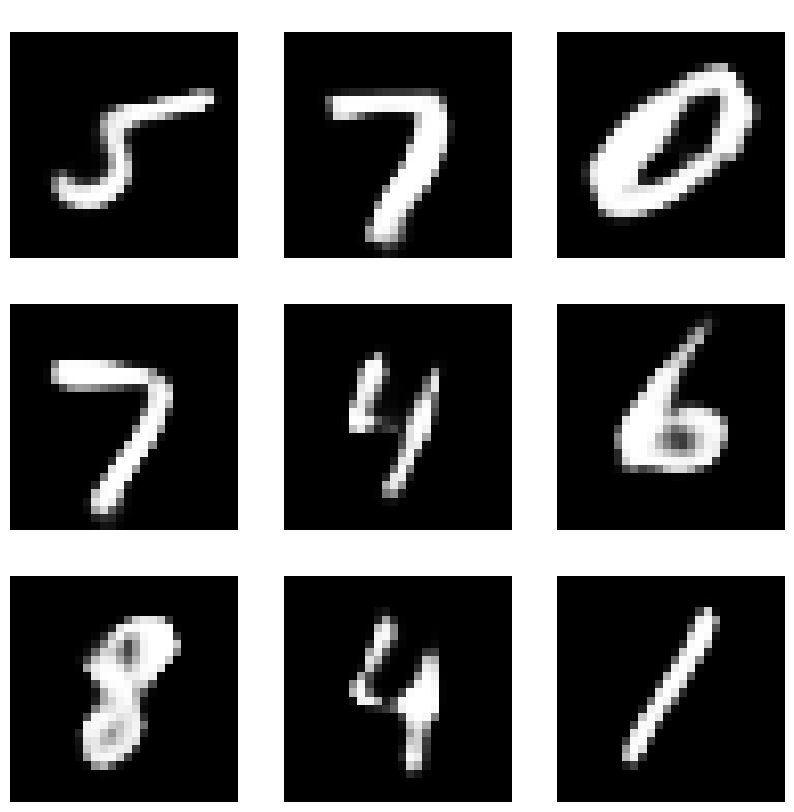

In [ ]:
from random import randint
from animation.util import backtransform_weights, reconstruct_image
from networks.mlp_models import MLP3D

ij_len = 3
# Plotting the tensors as heatmaps in grayscale
plt.style.use("dark_background")
fig, axes = plt.subplots(ij_len, ij_len, figsize=(10, 10))

fig.patch.set_alpha(0)

for ax in axes.flat:
    ax.patch.set_facecolor("none")
    ax.patch.set_alpha(0)


kwargs = {
"type": "pretrained",
"fixed_label": None,
}

for i in range(ij_len):
    for j in range(ij_len):

        model.eval()
        number = str(randint(0, 9))
        novel_tokens = model.generate(torch.Tensor([[token_dict["SOS"], token_dict[number]]]).long().to(device="cuda"), dataset[0][0].shape[0], temperature=0.8, top_k=3)[:, 1:]

        print(number)
        novel_tokens = novel_tokens[:, 1:].unsqueeze(-1).to("cpu")
                                                                                                                         

        max_similarity = 0
        """
        for data in dataset:
            similarity = (data[0].to(device)==noxmarty/resnet-tiny-mnist
                max_similarity = similarity
        """
        #print(f"Maximum Similarity of picture (i, j) {(i, j)}: {max_similarity}")

        novel_weights= vq.get_codes_from_indices((novel_tokens))

        dataset_no_transform = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), **kwargs)
        original_dict = dataset_no_transform[0][0]

        reconstructed_dict = backtransform_weights(novel_weights, original_dict["state_dict"])

        mlp3d = MLP3D(**original_dict["model_config"])
        mlp3d.load_state_dict(reconstructed_dict)
        reconstructed_tensor = reconstruct_image(mlp3d)

        axes[i][j].imshow(reconstructed_tensor, cmap='gray', aspect='auto')
        axes[i][j].set_title(number)
        axes[i][j].axis("off")

fig.patch.set_alpha(0)


plt.show()

In [ ]:
from training.mnist_classifier_score import compute_mnist_score
acc, loss= compute_mnist_score(model, vq, "cuda", token_dict)

print(acc)
print(loss)


0.703125
1.2872538566589355


In [ ]:
# script to 

In [ ]:
from utils.metrics import compute_all_metrics

reference =

compute_all_metrics()

In [ ]:
# get the logits of the gpt model generation
model.eval()
logits_conditioning = model.generate_logits(torch.Tensor([[token_dict["SOS"]]]).long().to(device="cuda"))

# do a whole autoregressive proccess and get the logits for the last token
novel_tokens = model.generate(torch.Tensor([[token_dict["SOS"]]]).long().to(device="cuda"), dataset[0][0].shape[0] + 1, temperature=0.8, top_k=3)[:, :]
logits_last = model.generate_logits(novel_tokens[:, :-1])

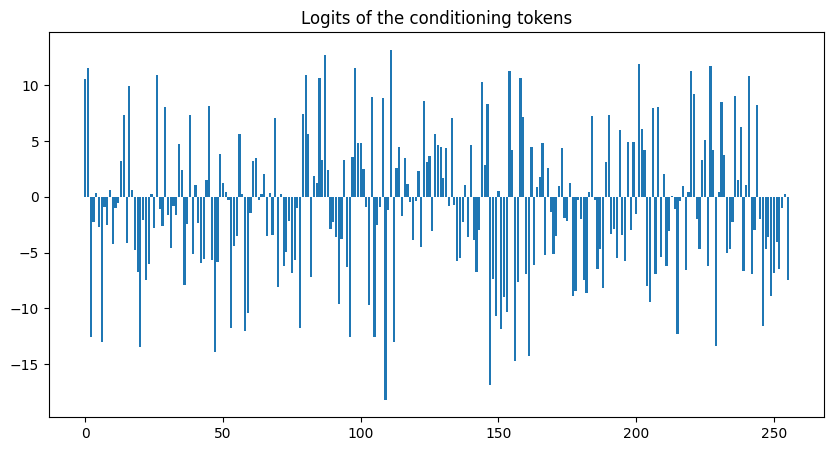

In [ ]:
# barchart of the logits
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(range(logits_last.shape[-1]), logits_last[0].detach().cpu().numpy())
ax.set_title("Logits of the conditioning tokens")
plt.show()

In [ ]:
logits

In [ ]:
# store the logits as numpy file
import numpy as np
np.save("logits_conditioning.npy", logits_conditioning.squeeze(0).detach().cpu().numpy())
np.save("logits_last.npy", logits_last.squeeze(0).detach().cpu().numpy())

Text(0.5, 1.0, 'Softmax of the logits of the conditioning tokens')

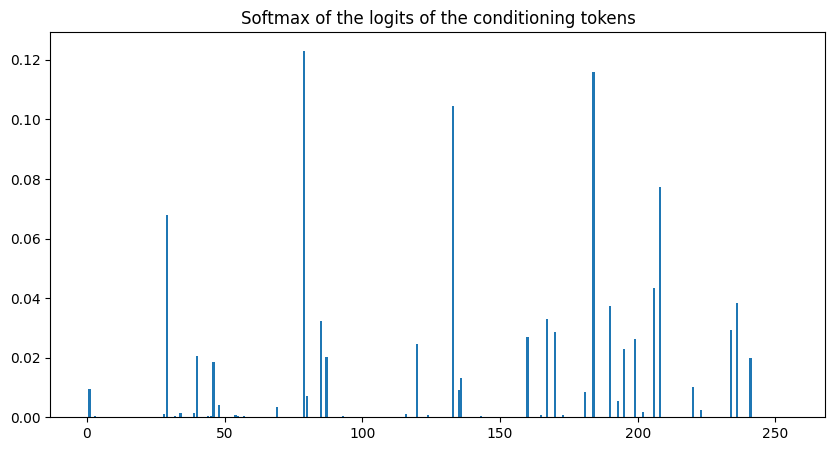

In [ ]:
# softmax of the logits conditioning
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
temperature = 2
logits = logits_last / temperature
ax.bar(range(logits_last.shape[-1]), torch.softmax(logits[0], dim=-1).detach().cpu().numpy())
ax.set_title("Softmax of the logits of the conditioning tokens")

In [ ]:
import optimize_metrics

optimize_metrics.main()

number of parameters: 5.62M
{'1': {'1': {'acc': 0.65625, 'loss': 1.4447228908538818}}}


{'1': {'1': {'acc': 0.65625, 'loss': 1.4447228908538818}}}